In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import os
import re
import unicodedata
import hdbscan
from sentence_transformers import SentenceTransformer
from openai import OpenAI
from dotenv import load_dotenv
import umap


/opt/anaconda3/envs/keath_project/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Load the JSON data
def load_json_data(filepath: str) -> list:
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            report_data = json.load(f)

        if report_data:
            if isinstance(report_data, list):
                print(f"Successfully loaded JSON. Found {len(report_data)} records.")
            else:
                print(f"Loaded JSON, but it's not a list. Type: {type(report_data)}. Handling appropriately.")
                report_data = [report_data] if isinstance(report_data, dict) else []
        else:
            print("WARNING: JSON file was loaded but appears to be empty or None.")
            report_data = []
        return report_data

    except FileNotFoundError:
        print(f"ERROR: File not found at '{filepath}'. Please check the path.")
    except json.JSONDecodeError as e:
        print(f"ERROR: Could not decode JSON from file {filepath}. The file may be corrupted. Error: {e}")
    except Exception as e:
        print(f"ERROR: An unexpected error occurred during file loading: {e}")
    return []

In [4]:
# Load the JSON data into DataFrames
actionability_df = pd.DataFrame(load_json_data('dataset/merged/merged_actionability.json'))
specificity_df = pd.DataFrame(load_json_data('dataset/merged/merged_specificity.json'))
rubric_alignment_df = pd.DataFrame(load_json_data('dataset/merged/merged_rubric_alignment.json'))
factual_consistency_df = pd.DataFrame(load_json_data('dataset/merged/merged_factual_consistency.json')) 

df = pd.concat([actionability_df, specificity_df, rubric_alignment_df, factual_consistency_df], ignore_index=True)
df.info()
df.head(5)


Successfully loaded JSON. Found 8634 records.
Successfully loaded JSON. Found 8634 records.
Successfully loaded JSON. Found 7023 records.
Successfully loaded JSON. Found 7023 records.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31314 entries, 0 to 31313
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   assignment_id  31314 non-null  int64  
 1   paper_content  31314 non-null  object 
 2   item           31314 non-null  object 
 3   type           31314 non-null  object 
 4   grader_score   31314 non-null  float64
 5   comment        31314 non-null  object 
 6   evidence       28092 non-null  object 
 7   score_range    28092 non-null  object 
 8   rubric         28092 non-null  object 
 9   metric         31314 non-null  object 
 10  judge_score    31314 non-null  float64
 11  status         31314 non-null  object 
 12  reason         31314 non-null  object 
dtypes: float64(2), int64(1), object(10)
memory

,assignment_id,paper_content,item,type,grader_score,comment,evidence,score_range,rubric,metric,judge_score,status,reason
0,0,BPP Business School Coursework Cover Sheet Ple...,"Presentation, Structure, and Referencing",sub_score,10.0,Positive Aspects: - The report is well-organiz...,"The report is well-organized, following the as...",7-10,The report is exceptionally well structured an...,Actionability [GEval],0.816704,passed,"The feedback comment provides specific, future..."
1,0,BPP Business School Coursework Cover Sheet Ple...,Task 1 - Management Practices,sub_score,14.0,Positive Aspects: - The submission effectively...,The submission clearly delineates Qatar Airway...,14-15,"Excellent analysis of Qatar Airways' mission, ...",Actionability [GEval],0.816339,passed,"The feedback comment provides explicit, future..."
2,0,BPP Business School Coursework Cover Sheet Ple...,Task 2 - Analysis of Business Challenges,sub_score,12.0,Positive Aspects: - Successfully identifies ke...,The submission outlines significant challenges...,12-13,Identifies significant challenges and discusse...,Actionability [GEval],0.769652,passed,"The feedback comment provides explicit, future..."
3,0,BPP Business School Coursework Cover Sheet Ple...,Task 3 - Management Behaviors of Emotional Int...,sub_score,13.0,Positive Aspects: - Acknowledges the importanc...,The submission provides a general discussion o...,12-13,Good evaluation showing general effects of Emo...,Actionability [GEval],0.801688,passed,"The feedback comment provides explicit, future..."
4,0,BPP Business School Coursework Cover Sheet Ple...,Task 4 - Management Competencies Development,sub_score,18.0,Positive Aspects: - Identifies competencies re...,The submission identifies some competencies bu...,18-20,Competent assessment of management competencie...,Actionability [GEval],0.777350,passed,"The feedback comment provides explicit, future..."


In [5]:
actionability_sample = actionability_df.head(100)

### QUALITATIVE ANALYSIS

#### Semantic AnALYSIS


Cluster for Acionability (for Exploration)

In [6]:
# Load a pretrained Sentence Transformer model
model = SentenceTransformer("all-MiniLM-L6-v2")

# Generate embeddings for each metric
actionability_sample_embeddings = model.encode(actionability_sample['reason'].to_list(), show_progress_bar=True)
actionability_embeddings = model.encode(actionability_df['reason'].to_list(), show_progress_bar=True)
# specificity_embeddings = model.encode(specificity_df['reason'].to_list(), show_progress_bar=True)
# rubric_alignment_embeddings = model.encode(rubric_alignment_df['reason'].to_list(), show_progress_bar=True)
# factual_consistency_embeddings = model.encode(factual_consistency_df['reason'].to_list(), show_progress_bar=True)
# print(f"Embeddings generated with shape: {actionability_embeddings.shape, specificity_embeddings.shape, rubric_alignment_embeddings.shape, factual_consistency_embeddings.shape}")

Batches:   0%|          | 0/4 [00:00<?, ?it/s]/opt/anaconda3/envs/keath_project/lib/python3.11/site-packages/torch/nn/modules/module.py:1520: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Batches: 100%|██████████| 270/270 [02:10<00:00,  2.06it/s]


In [17]:
print("Running HDBSCAN clustering per Metric...")

# Initialize HDBSCAN clusterer
# Adjust min_cluster_size and min_samples as needed for your dataset
clusterer1 = hdbscan.HDBSCAN(min_cluster_size=10,
                            # min_samples=5,
                          metric='euclidean',
                          prediction_data=True)

clusterer2 = hdbscan.HDBSCAN(min_cluster_size=5,
                            min_samples=2,
                          metric='euclidean',
                          prediction_data=True)


# Fit and predict clusters for each metric
actionability_cluster_labels = clusterer1.fit_predict(actionability_embeddings)
actionability_sample_cluster_labels = clusterer2.fit_predict(actionability_sample_embeddings)
# specificity_cluster_labels = clusterer.fit_predict(specificity_embeddings)
# rubric_alignment_cluster_labels = clusterer.fit_predict(rubric_alignment_embeddings)
# factual_consistency_cluster_labels = clusterer.fit_predict(factual_consistency_embeddings)


print("Clustering complete.")

Running HDBSCAN clustering per Metric...


/opt/anaconda3/envs/keath_project/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/keath_project/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Clustering complete.


/opt/anaconda3/envs/keath_project/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/keath_project/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [18]:
# Create DataFrames to hold the clustering results Per Metric


# actionability_clustering_results = pd.DataFrame({
#     'reason': actionability_df_failed['reason'],
#     'status': actionability_df_failed['status'],
#     'judge_score': actionability_df_failed['judge_score'],
#     'cluster': actionability_cluster_labels
# })

actionability_clustering_results = pd.DataFrame({
    'reason': actionability_df['reason'],
    'status': actionability_df['status'],
    'judge_score': actionability_df['judge_score'],
    'cluster': actionability_cluster_labels
})

actionability_sample_clustering_results = pd.DataFrame({
    'reason': actionability_sample['reason'],
    'status': actionability_sample['status'],
    'judge_score': actionability_sample['judge_score'],
    'cluster': actionability_sample_cluster_labels
})

# specificity_clustering_results = pd.DataFrame({
#     'reason': specificity_df['reason'],
#     'status': specificity_df['status'], 
#     'judge_score': specificity_df['judge_score'],
#     'cluster': specificity_cluster_labels
# })

# rubric_alignment_clustering_results = pd.DataFrame({
#     'reason': rubric_alignment_df['reason'],
#     'status': rubric_alignment_df['status'],
#     'judge_score': rubric_alignment_df['judge_score'],
#     'cluster': rubric_alignment_cluster_labels
# })

# factual_consistency_clustering_results = pd.DataFrame({
#     'reason': factual_consistency_df['reason'],
#     'status': factual_consistency_df['status'],
#     'judge_score': factual_consistency_df['judge_score'],
#     'cluster': factual_consistency_cluster_labels
# })

# actionability_clustering_results['cluster'].value_counts()
# actionability_clustering_results
# specificity_clustering_results['cluster'].value_counts()
# specificity_clustering_results
# rubric_alignment_clustering_results['cluster'].value_counts()
# rubric_alignment_clustering_results
# factual_consistency_clustering_results['cluster'].value_counts()
# factual_consistency_clustering_results

Cluster Visualization

Sample_Actionability

Running UMAP to create 2D projection...


/opt/anaconda3/envs/keath_project/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP complete.
Generating plot...


<Figure size 1400x1000 with 0 Axes>

Text(0.5, 1.0, '2D UMAP Visualization of Actionability Themes')

Text(0.5, 0, 'UMAP Dimension 1')

Text(0, 0.5, 'UMAP Dimension 2')

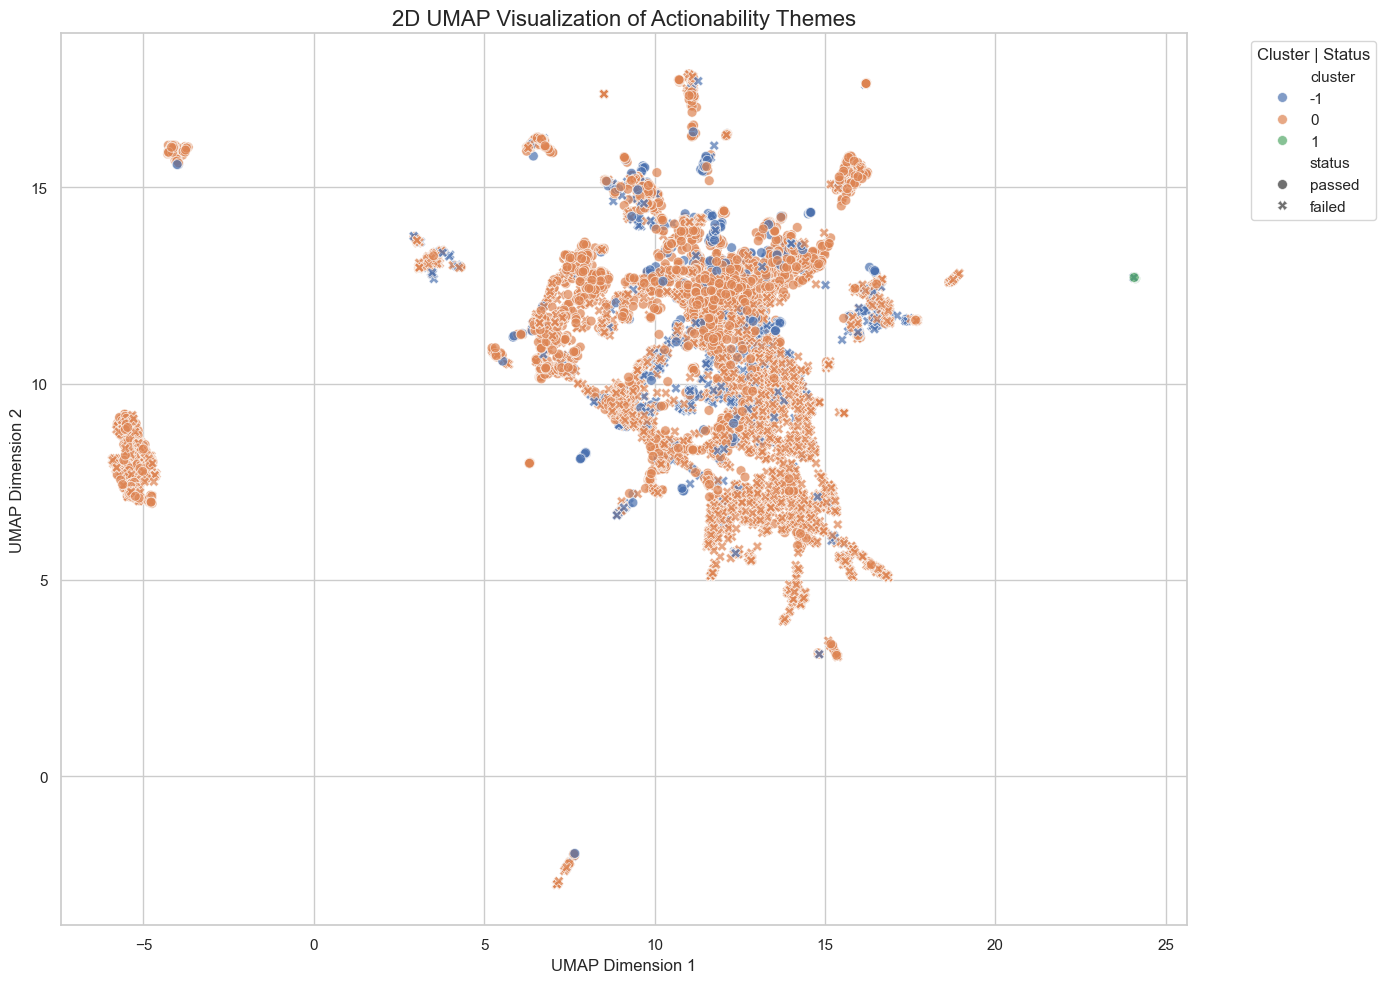

In [19]:
# 1. Reduce Dimensions using UMAP
print("Running UMAP to create 2D projection...")
reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
embedding_2d = reducer.fit_transform(actionability_embeddings)

# 2. Add the 2D coordinates to your DataFrame
actionability_clustering_results['umap_x'] = embedding_2d[:, 0]
actionability_clustering_results['umap_y'] = embedding_2d[:, 1]
print("UMAP complete.")

# 3. Create the Scatter Plot
print("Generating plot...")
plt.figure(figsize=(14, 10))
sns.set_theme(style="whitegrid")

# Create a scatter plot, coloring by cluster and shaping by status
plot = sns.scatterplot(
    data=actionability_clustering_results,
    x='umap_x',
    y='umap_y',
    hue='cluster',        # Color points by their theme/cluster
    style='status',       # Use different shapes for 'passed' vs 'failed'
    palette='deep',       # A vibrant color palette
    s=50,                 # Marker size
    alpha=0.7             # Marker transparency
)

plt.title('2D UMAP Visualization of Actionability Themes', fontsize=16)
plt.xlabel('UMAP Dimension 1', fontsize=12)
plt.ylabel('UMAP Dimension 2', fontsize=12)
plt.legend(title='Cluster | Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Full_Actionability

Running UMAP to create 2D projection...


/opt/anaconda3/envs/keath_project/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP complete.
Generating plot...


<Figure size 1400x1000 with 0 Axes>

Text(0.5, 1.0, '2D UMAP Visualization of Actionability Themes | Sample Size')

Text(0.5, 0, 'UMAP Dimension 1')

Text(0, 0.5, 'UMAP Dimension 2')

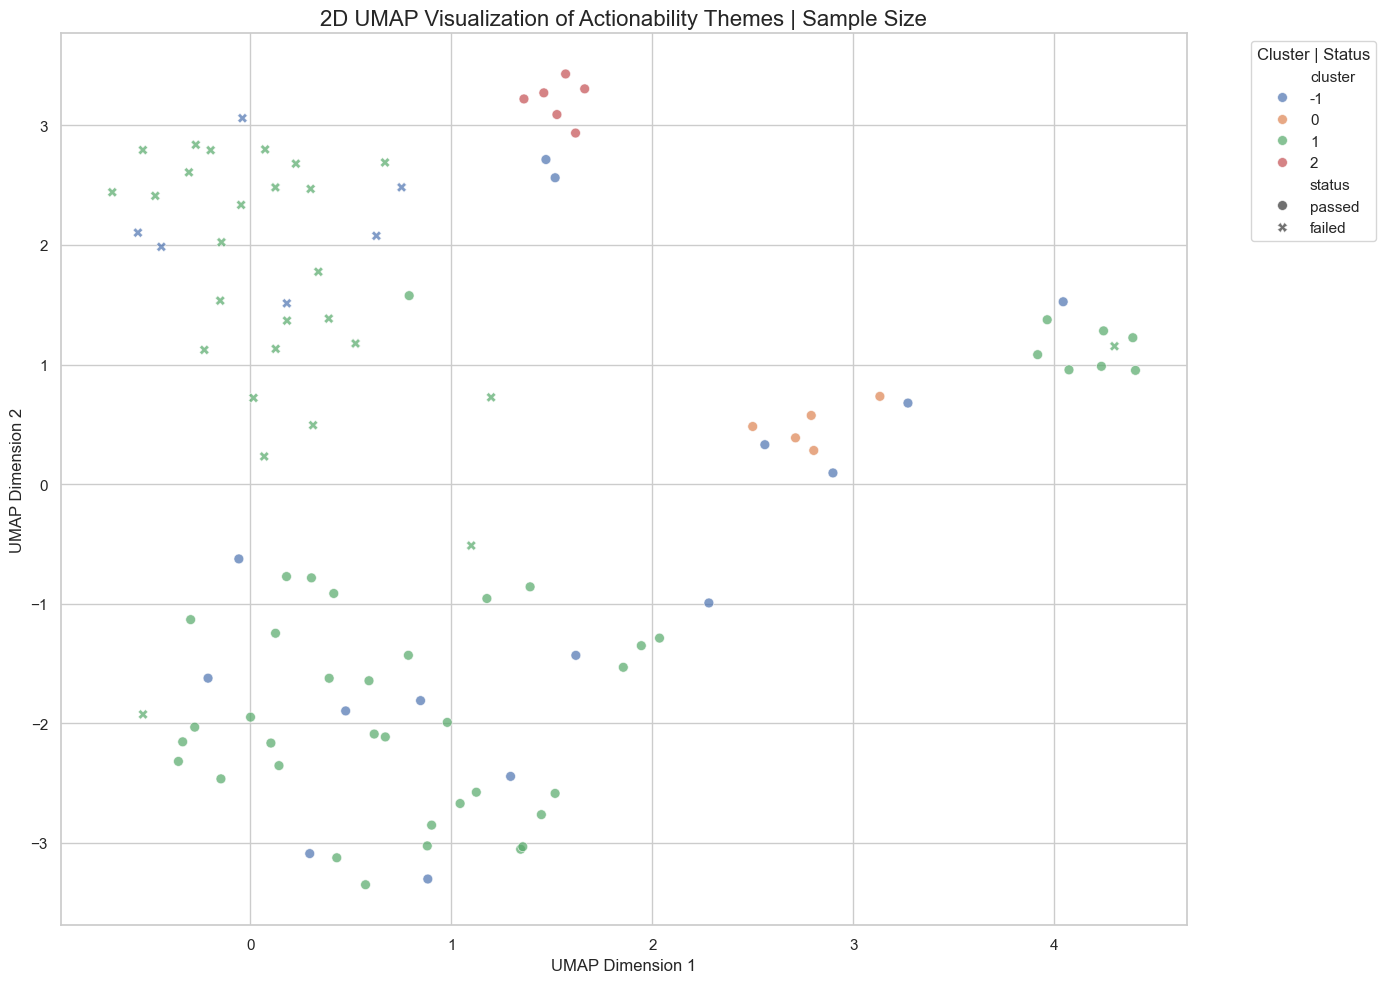

In [20]:
# 1. Reduce Dimensions using UMAP
print("Running UMAP to create 2D projection...")
reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
embedding_2d = reducer.fit_transform(actionability_sample_embeddings)

# 2. Add the 2D coordinates to your DataFrame
actionability_sample_clustering_results['umap_x'] = embedding_2d[:, 0]
actionability_sample_clustering_results['umap_y'] = embedding_2d[:, 1]
print("UMAP complete.")

# 3. Create the Scatter Plot
print("Generating plot...")
plt.figure(figsize=(14, 10))
sns.set_theme(style="whitegrid")

# Create a scatter plot, coloring by cluster and shaping by status
plot = sns.scatterplot(
    data=actionability_sample_clustering_results,
    x='umap_x',
    y='umap_y',
    hue='cluster',        # Color points by their theme/cluster
    style='status',       # Use different shapes for 'passed' vs 'failed'
    palette='deep',       # A vibrant color palette
    s=50,                 # Marker size
    alpha=0.7             # Marker transparency
)

plt.title('2D UMAP Visualization of Actionability Themes | Sample Size', fontsize=16)
plt.xlabel('UMAP Dimension 1', fontsize=12)
plt.ylabel('UMAP Dimension 2', fontsize=12)
plt.legend(title='Cluster | Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Cluster by OpenAI

In [ ]:
import pandas as pd
from openai import OpenAI

client = OpenAI()
MODEL = "gpt-4o-mini"

DEFICIENCY_CATEGORIES = [
    'Lacks of Actionable Guidance',
    'Poor Tone',
    'No Deficiency Found'
]

def get_deficiency(reason_text):
    """Finds and categorizes only what the feedback lacks."""
    system_prompt = f"""
    You are a deficiency-finding tool. Your ONLY task is to read the following text and identify what it says the original feedback *lacks* or *could improve upon*. This critique is usually found after the word "However". Ignore all praise and positive comments.

    Classify the single main deficiency into ONE of the following categories.

    DEFICIENCY CATEGORIES:
    {', '.join(DEFICIENCY_CATEGORIES)}

    Output only the single, exact category name from the list.
    """
    try:
        response = client.chat.completions.create(
            model=MODEL,
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": f"REASON TEXT:\n'{reason_text}'\n\nDEFICIENCY:"}
            ],
            temperature=0, max_tokens=20
        )
        category = response.choices[0].message.content.strip()
        return category if category in DEFICIENCY_CATEGORIES else 'Other'
    except Exception as e:
        return f"API_Error: {e}"

# Apply this to your full DataFrame
actionability_df['deficiency'] = actionability_df['reason'].apply(get_deficiency)

# Get the final counts 
final_breakdown = actionability_df['deficiency'].value_counts()
print(final_breakdown)

# Breakdown by Status 
# This will give you a count of deficiencies by status (passed/failed)
breakdown = actionability_df.groupby('status')['deficiency'].value_counts()
print(breakdown)

deficiency
Lacks of Actionable Guidance    73
Poor Tone                       20
No Deficiency Found              7
Name: count, dtype: int64


### QUANTITATIVE ANALYSIS

### Overall Performance Distribution

In [15]:
df['metric'].value_counts()

metric
Actionability [GEval]          8634
Specificity [GEval]            8634
Rubric Alignment [GEval]       7023
Factual Consistency [GEval]    7023
Name: count, dtype: int64

In [16]:
df.groupby('metric')['judge_score'].describe()

,count,mean,std,min,25%,50%,75%,max
metric,,,,,,,,
Actionability [GEval],8634.0,0.628727,0.215041,0.000000,0.465049,0.680688,0.816482,0.909535
Factual Consistency [GEval],7023.0,0.733297,0.219472,0.001799,0.676377,0.809023,0.877630,1.000000
Rubric Alignment [GEval],7023.0,0.758263,0.190196,0.000000,0.703879,0.812770,0.878092,1.000000
Specificity [GEval],8634.0,0.569964,0.190069,0.002931,0.428745,0.605976,0.728057,0.919022


<Axes: xlabel='metric', ylabel='judge_score'>

([0, 1, 2, 3],
 [Text(0, 0, 'Actionability [GEval]'),
  Text(1, 0, 'Specificity [GEval]'),
  Text(2, 0, 'Rubric Alignment [GEval]'),
  Text(3, 0, 'Factual Consistency [GEval]')])

Text(0.5, 1.0, 'Judge Score Distribution per Metric')

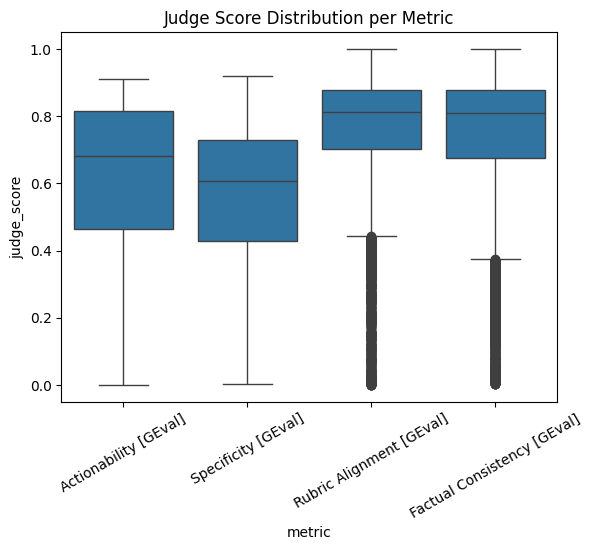

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting the distribution of judge scores for each metric
sns.boxplot(data=df, x='metric', y='judge_score')
plt.xticks(rotation=30)
plt.title('Judge Score Distribution per Metric')
plt.show()

<Axes: xlabel='metric'>

Text(0.5, 1.0, 'Pass/Fail Rate by Metric')

Text(0, 0.5, 'Proportion')

Text(0.5, 0, 'Metric')

(array([0, 1, 2, 3]),
 [Text(0, 0, 'Actionability [GEval]'),
  Text(1, 0, 'Specificity [GEval]'),
  Text(2, 0, 'Rubric Alignment [GEval]'),
  Text(3, 0, 'Factual Consistency [GEval]')])

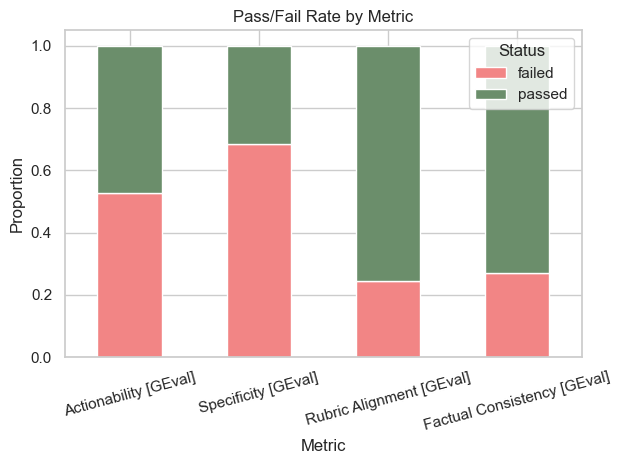

In [38]:
# # Plotting the pass/fail rate by metric
# df.groupby('metric')['status'].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True)
# plt.title('Pass/Fail Rate by Metric')
# plt.ylabel('Proportion')


# Define custom order
metric_order = ['Actionability [GEval]', 'Specificity [GEval]', 'Rubric Alignment [GEval]', 'Factual Consistency [GEval]']

# Group, normalize, and reorder
plot_data = (
    df.groupby('metric')['status']
    .value_counts(normalize=True)
    .unstack()
    .reindex(metric_order)
)

# Custom colors: subtle red for failed, green for passed
colors = ["#F28585", "#6b8e6b"]  # failed, passed

# Plot
plot_data.plot(kind='bar', stacked=True, color=colors)
plt.title('Pass/Fail Rate by Metric')
plt.ylabel('Proportion')
plt.xlabel('Metric')
plt.xticks(rotation=15)
plt.legend(title='Status', loc='upper right')
plt.tight_layout()
plt.show()

[Text(0, 0, 'Actionability [GEval]'),
 Text(0, 1, 'Specificity [GEval]'),
 Text(0, 2, 'Rubric Alignment [GEval]'),
 Text(0, 3, 'Factual Consistency [GEval]')]

(0.0, 100.0)

Text(0.5, 0, 'Proportion (%)')

Text(0.5, 1.0, 'Pass/Fail Rate by Metric')

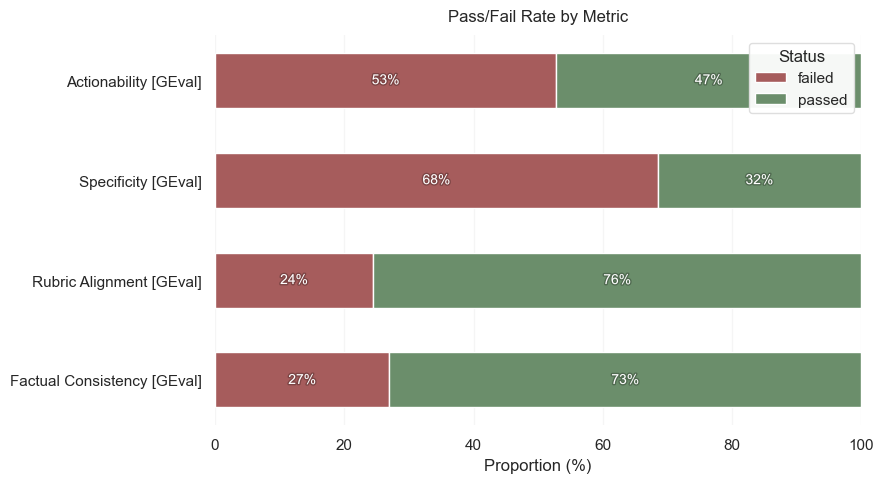

In [43]:
import numpy as np
import matplotlib.pyplot as plt

metric_order = [
    'Actionability [GEval]',
    'Specificity [GEval]',
    'Rubric Alignment [GEval]',
    'Factual Consistency [GEval]'
]

df = df.copy()
df['status'] = df['status'].str.lower().str.strip()

plot_data = (
    df.groupby('metric')['status']
      .value_counts(normalize=True)
      .unstack(fill_value=0.0)
      .reindex(metric_order)
      .reindex(columns=['failed','passed'], fill_value=0.0)
)

FAIL = '#a65c5c'
PASS = '#6b8e6b'

fig, ax = plt.subplots(figsize=(9, 5))

y = np.arange(len(plot_data))
failed = (plot_data['failed'] * 100).to_numpy()
passed = (plot_data['passed'] * 100).to_numpy()

bars1 = ax.barh(y, failed, color=FAIL, edgecolor='white', height=0.55, label='failed', zorder=2)
bars2 = ax.barh(y, passed, left=failed, color=PASS, edgecolor='white', height=0.55, label='passed', zorder=2)

# % labels (normal weight, small outline for readability)
import matplotlib.patheffects as pe
def annotate(vals, lefts):
    for yi, (v, l) in enumerate(zip(vals, lefts)):
        if v >= 6:
            ax.text(l + v/2, yi, f"{v:.0f}%", ha='center', va='center',
                    color='white', fontsize=10,
                    path_effects=[pe.withStroke(linewidth=2, foreground='black', alpha=0.25)])

annotate(failed, np.zeros_like(failed))
annotate(passed, failed)

# Grid (x only, subtle)
ax.xaxis.grid(True, linestyle='-', alpha=0.18, zorder=1)
ax.set_axisbelow(True)

# Ticks/labels
ax.set_yticks(y)
ax.set_yticklabels(metric_order)
ax.set_xlim(0, 100)
ax.invert_yaxis()
ax.set_xlabel('Proportion (%)')
ax.set_title('Pass/Fail Rate by Metric', pad=10)

# Legend: make “Status” visible and clean
leg = ax.legend(title='Status', loc='upper right', frameon=True, fancybox=True, framealpha=0.95)
leg.get_frame().set_edgecolor('#dddddd')

# De-clutter spines
for s in ['top','right','left','bottom']:
    ax.spines[s].set_visible(False)

plt.tight_layout()
plt.show()

### Actionability & Specificity

#### Total_Score

In [19]:
# Check for any grader scores above 100
df['grader_score'].describe()
df[df['grader_score'] > 100].count()

# Drop the rows with grader_score > 100
df = df[df['grader_score'] <= 100]
df[df['grader_score'] > 100].count()


count    31314.000000
mean        25.906975
std         31.077929
min          0.000000
25%          2.000000
50%         10.000000
75%         55.000000
max        535.000000
Name: grader_score, dtype: float64

assignment_id    32
paper_content    32
item             32
type             32
grader_score     32
comment          32
evidence          0
score_range       0
rubric            0
metric           32
judge_score      32
status           32
reason           32
dtype: int64

assignment_id    0
paper_content    0
item             0
type             0
grader_score     0
comment          0
evidence         0
score_range      0
rubric           0
metric           0
judge_score      0
status           0
reason           0
dtype: int64

,assignment_id,paper_content,item,type,grader_score,comment,evidence,score_range,rubric,metric,judge_score,status,reason
122,36,Behavioral Practice My Interpretation of the M...,Total Score,score,58.0,"You've made a solid start on your PDP, capturi...",None,None,None,Actionability [GEval],0.873106,passed,"The feedback comment provides explicit, future..."
123,37,Behavioral Practice My Interpretation of the M...,Total Score,score,73.0,"You've made a solid start with your PDP, captu...",None,None,None,Actionability [GEval],0.877730,passed,"The feedback comment provides explicit, future..."
124,38,Behavioral Practice My Interpretation of the M...,Total Score,score,60.0,"You've made a solid start on your PDP, showing...",None,None,None,Actionability [GEval],0.892484,passed,"The feedback comment provides explicit, future..."
125,39,Behavioral Practice My Interpretation of the M...,Total Score,score,63.0,"You've made a solid start on your PDP, capturi...",None,None,None,Actionability [GEval],0.883548,passed,"The feedback comment provides explicit, future..."
126,40,Behavioral Practice My Interpretation of the M...,Total Score,score,63.0,"You've made a solid start on your PDP, capturi...",None,None,None,Actionability [GEval],0.881757,passed,"The feedback comment provides explicit, future..."


<Axes: >

Text(0.5, 1.0, 'Distribution of Total Scores')

Text(0.5, 0, 'Total Score')

Text(0, 0.5, 'Frequency')

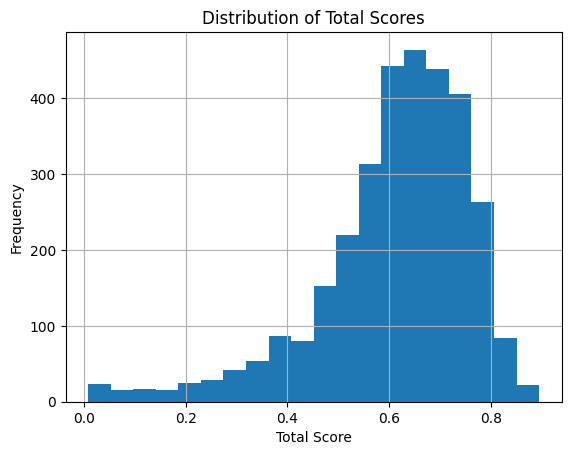

<Axes: xlabel='metric', ylabel='Count'>

Text(0.5, 1.0, 'Pass/Fail Rate for Total Score Feedback')

Text(0.5, 0, 'Metric')

Text(0, 0.5, 'Count')

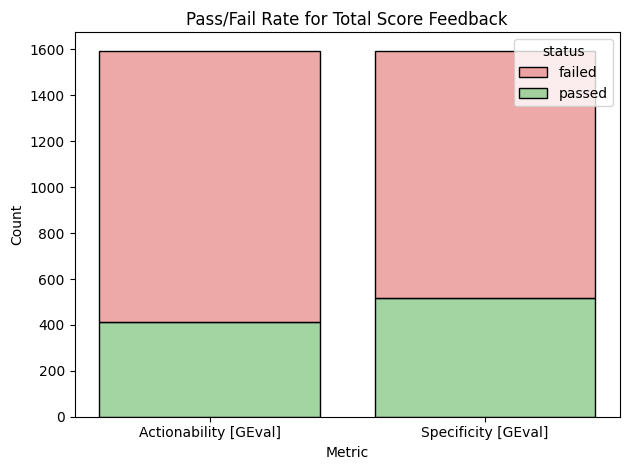

In [20]:
# Filter the DataFrame for total score evaluations
df_total_score = df[df['type'] == 'score']
df_total_score[df_total_score['status'] == 'passed'].head(5)


# Plotting the distribution of total scores
df_total_score['judge_score'].hist(bins=20)
plt.title('Distribution of Total Scores')
plt.xlabel('Total Score')
plt.ylabel('Frequency')
plt.show()


# Create the histogram (stacked bar plot)
sns.histplot(
    data=df_total_score,
    x='metric',
    hue='status',
    multiple='stack',
    shrink=0.8,
    palette={'failed': '#e88b8b', 'passed': '#84c884'}
)
plt.title('Pass/Fail Rate for Total Score Feedback')
plt.xlabel('Metric')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [ ]:
# Compare the pass rate of Total Score rows vs non-Total Score rows

print("--- Pass Rate Comparison: 'Total Score' vs. 'Other Rows' ---")

# Create a boolean column for pass/fail status
df['is_passed'] = (df['status'] == 'passed')

# Create a column to categorize the feedback type
df['feedback_category'] = np.where(df['type'] == 'score', 'Total Score Rows', 'Other (Sub-Score) Rows')

# Filter for only the metrics we care about
# The original filtering is fine, but we can simplify since we're analyzing all metrics in the df
analysis_df = df[df['metric'].isin(['Actionability [GEval]', 'Specificity [GEval]'])]


# Perform the groupby to calculate pass rates
pass_rate_breakdown = analysis_df.groupby(['metric', 'feedback_category'])['is_passed'].mean().unstack() * 100


# Print the results table
print(pass_rate_breakdown.to_string(float_format="%.2f%%"))


# Drop the 'is_passed' column as it's no longer needed
df.drop(columns=['is_passed'], inplace=True)



--- Pass Rate Comparison: 'Total Score' vs. 'Other Rows' ---
feedback_category      Other (Sub-Score) Rows  Total Score Rows
metric                                                         
Actionability [GEval]                  52.10%            25.96%
Specificity [GEval]                    31.35%            32.41%


--- Correlation Analysis for 'Total Score' Feedback ---
The correlation between the Grader LLM's score and the Judge LLM's quality score is: 0.36
The p-value is < 0.001
The correlation is statistically significant.


<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='grader_score', ylabel='judge_score'>

<Axes: xlabel='grader_score', ylabel='judge_score'>

Text(0.5, 1.0, 'Correlation between Grader Score and Judge Score for Pedagogical Metrics')

Text(0.5, 0, 'Original Grader LLM Score')

Text(0, 0.5, "Judge LLM's Quality Score")

Text(0.05, 0.9, 'Correlation: 0.36\np-value: 0.00')

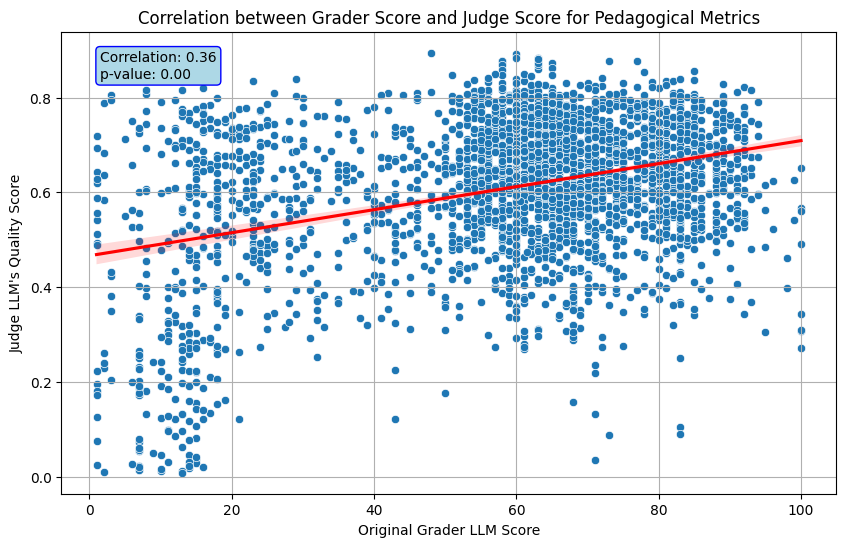

In [22]:
# Calculate the Correlation between Grader and Judge Scores and Statistical Significance 
correlation, p_value = pearsonr(df_total_score['grader_score'], df_total_score['judge_score'])

print(f"--- Correlation Analysis for 'Total Score' Feedback ---")
print(f"The correlation between the Grader LLM's score and the Judge LLM's quality score is: {correlation:.2f}")

# --- Interpret the p-value ---
if p_value < 0.001:
    print("The p-value is < 0.001")
else:
    print(f"The p-value is: {p_value:.4f}")

if p_value < 0.05:
    print("The correlation is statistically significant.")
else:
    print("The correlation is not statistically significant.")

# --- Visualize the Correlation with a Scatter Plot ---
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_total_score, x='grader_score', y='judge_score')
sns.regplot(data=df_total_score, x='grader_score', y='judge_score', scatter=False, color='red')

plt.title('Correlation between Grader Score and Judge Score for Pedagogical Metrics')
plt.xlabel("Original Grader LLM Score")
plt.ylabel("Judge LLM's Quality Score")
# Adding the correlation and p-value to the plot
plt.annotate(f'Correlation: {correlation:.2f}\np-value: {p_value:.2f}',
             xy=(0.05, 0.9), xycoords='axes fraction',
             bbox=dict(boxstyle="round,pad=0.3", fc="lightblue", ec="b", lw=1))
plt.grid(True)

             min    max       mean        std  count
grader_bin                                          
Low          1.0   59.0  35.810469  18.907663   1108
Medium      60.0   70.0  64.636872   2.958612   1074
High        71.0  100.0  80.407738   6.611425   1008


/var/folders/gl/0z9c8j8x38145vq7j3xh6f640000gn/T/ipykernel_18591/1964728646.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_total_score['grader_bin'] = pd.qcut(
/var/folders/gl/0z9c8j8x38145vq7j3xh6f640000gn/T/ipykernel_18591/1964728646.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df_total_score.groupby('grader_bin')['grader_score'].agg(['min', 'max', 'mean', 'std', 'count']))


<Figure size 800x600 with 0 Axes>

<Axes: xlabel='grader_bin', ylabel='judge_score'>

Text(0.5, 1.0, 'Judge LLM Scores by Grader LLM Performance Tier')

Text(0.5, 0, 'Grader LLM Performance Tier')

Text(0, 0.5, 'Judge LLM Score')

(0.0, 1.0)

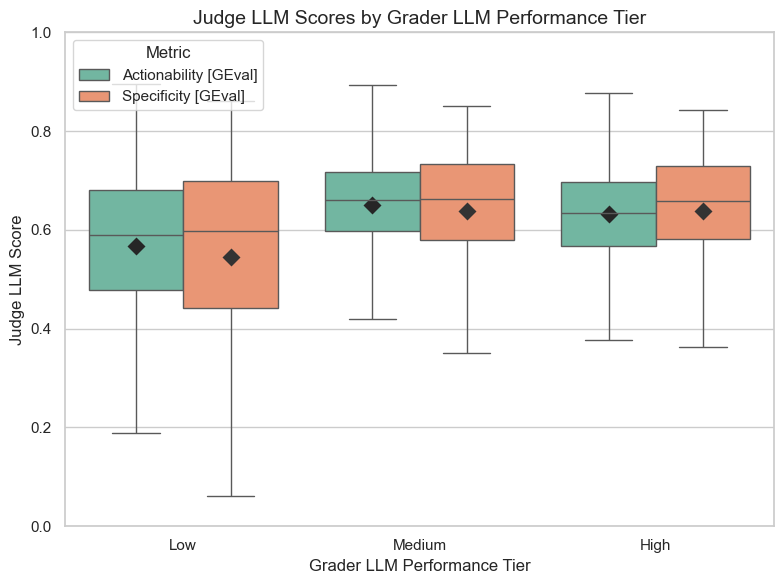

In [ ]:
# Bin grader scores into Low/Medium/High
df_total_score['grader_bin'] = pd.qcut(
    df_total_score['grader_score'],
    q=3,
    labels=['Low', 'Medium', 'High']
)

# Sanity check bin distribution
print(df_total_score.groupby('grader_bin')['grader_score'].agg(['min', 'max', 'mean', 'std', 'count']))

# Set seaborn style
sns.set_theme(style="whitegrid")

# Create boxplot
plt.figure(figsize=(8, 6))
ax = sns.boxplot(
    data=df_total_score,
    x='grader_bin',
    y='judge_score',
    hue='metric',
    palette='Set2',
    showfliers=False  # hides extreme outliers for a cleaner look
)

# Overlay mean points
sns.pointplot(
    data=df_total_score,
    x='grader_bin',
    y='judge_score',
    hue='metric',
    estimator='mean',
    errorbar=None,
    markers='D',
    linestyles='',
    dodge=0.4,  # separates dots from box centers
    palette='dark:#333333'  # dark grey for visibility
)

# Clean up labels & legend
ax.set_title('Judge LLM Scores by Grader LLM Performance Tier', fontsize=14)
ax.set_xlabel('Grader LLM Performance Tier')
ax.set_ylabel('Judge LLM Score')
plt.ylim(0, 1)

# Merge duplicate legends from boxplot + pointplot
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[:2], labels[:2], title='Metric', loc='upper left')

plt.tight_layout()
plt.show()


### Rubric Alignment & Factual Consistency

### Assignment-Level Trends

In [14]:
import pandas as pd
import numpy as np

def get_assignment_level_stats(df):
    
    # 1. Create a boolean 'is_failed' column for easy counting
    df['is_failed'] = (df['status'] == 'failed')
    
    # 2. Group by both assignment and metric, then aggregate
    # .agg() allows us to perform multiple calculations at once
    assignment_stats = df.groupby(['assignment_id', 'metric']).agg(
        average_score=('judge_score', 'mean'),
        failed_count=('is_failed', 'sum')
    )
    
    # Convert failed_count to integer
    assignment_stats['failed_count'] = assignment_stats['failed_count'].astype(int)
    
    return assignment_stats


# Call the function with your DataFrame
assignment_summary = get_assignment_level_stats(df)

# Drop the 'is_failed' column as it's no longer needed
df.drop(columns=['is_failed'], inplace=True)

# Display the assignment-level statistics
print("--- Assignment-Level Statistics ---")
print(assignment_summary)

--- Assignment-Level Statistics ---
                                           average_score  failed_count
assignment_id metric                                                  
0             Actionability [GEval]             0.738272             1
              Factual Consistency [GEval]       0.738258             2
              Rubric Alignment [GEval]          0.571550             3
              Specificity [GEval]               0.496559             6
1             Actionability [GEval]             0.783970             1
...                                                  ...           ...
1691          Specificity [GEval]               0.134599             5
1692          Actionability [GEval]             0.646547             3
              Factual Consistency [GEval]       0.717239             2
              Rubric Alignment [GEval]          0.387271             3
              Specificity [GEval]               0.391010             4

[5868 rows x 2 columns]


In [15]:
# Assume 'assignment_summary' is the DataFrame from your screenshot

# Sum the failures for each assignment
total_failures_per_assignment = assignment_summary.groupby('assignment_id')['failed_count'].sum()

# Sort to find the assignments with the most failures
worst_assignments = total_failures_per_assignment.sort_values(ascending=False)

print("--- Top 5 Assignments with the Most Failures ---")
print(worst_assignments.head(5))

--- Top 5 Assignments with the Most Failures ---
assignment_id
601    91
953    56
908    56
894    54
931    53
Name: failed_count, dtype: int64


In [16]:
# Sort by a specific metric's average score to find the worst performers
worst_in_actionability = assignment_summary.xs('Actionability [GEval]', level='metric').sort_values('average_score')

print("\n--- Top 5 Worst Assignments for Actionability ---")
print(worst_in_actionability.head(5))


--- Top 5 Worst Assignments for Actionability ---
               average_score  failed_count
assignment_id                             
931                 0.172685            19
920                 0.205125            19
914                 0.214052            17
912                 0.217962            13
75                  0.224177             1


### Cross - Metric Correlation 

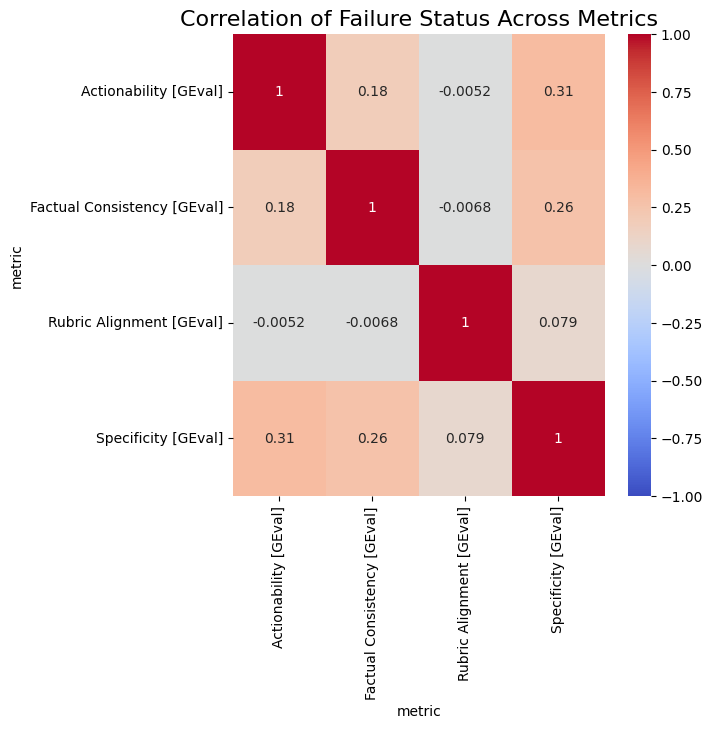

In [6]:
# Function to calculate and visualize the correlation of failure status across metrics
def calculate_and_visualize_failure_correlation(df):

    # Create a boolean 'is_failed' column from your 'status' column
    df['is_failed'] = (df['status'] == 'failed')
    
    # Pivot the data from long to wide format
    # This creates a table where each row is a unique feedback item and each column is a metric.
    # The values in the table will be True/False for whether that item failed the metric.
    wide_df = df.pivot_table(
        index=['assignment_id'], 
        columns='metric', 
        values='is_failed'
    )
    
    # Calculate the correlation matrix on the wide-format data
    correlation_matrix = wide_df.corr()
    
    # Visualize the correlation matrix as a heatmap
    plt.figure(figsize=(6, 6))
    sns.heatmap(
        correlation_matrix, 
        annot=True,       # Show the correlation values on the map
        cmap='coolwarm',  # Use a diverging color map
        vmin=-1, vmax=1   # Set the color scale from -1 to 1
    )
    plt.title('Correlation of Failure Status Across Metrics', fontsize=16)
    plt.show()
    

# Call the function with your DataFrame
correlation_results = calculate_and_visualize_failure_correlation(df)

# Drop the 'is_failed' column as it's no longer needed
df.drop(columns=['is_failed'], inplace=True)



### Examples for Appendix


In [ ]:
# Define the two metrics you want to keep
metrics_to_keep1 = ['Actionability [GEval]']
metrics_to_keep2 = ['Specificity [GEval]']
metrics_to_keep3 = ['Rubric Alignment [GEval]']
metrics_to_keep4 = ['Factual Consistency [GEval]']


# Filter the DataFrame to only include rows with those two metrics
filtered_df1 = df[df['metric'].isin(metrics_to_keep1)]
filtered_df2 = df[df['metric'].isin(metrics_to_keep2)]
filtered_df3 = df[df['metric'].isin(metrics_to_keep3)]
filtered_df4 = df[df['metric'].isin(metrics_to_keep4)]


# Group by both metric and status, then take the first a row from each group
sampled_df1 = filtered_df1.groupby(['metric', 'status']).head(5)
sampled_df2 = filtered_df2.groupby(['metric', 'status']).head(5)
sampled_df3 = filtered_df3.groupby(['metric', 'status']).head(5)
sampled_df4 = filtered_df4.groupby(['metric', 'status']).head(5)


# Group by both metric and status, then take the first a row from each group
# sampled_df = df.groupby(['metric', 'status']).head(1)

# Select and order the columns to display
appendix_table1 = sampled_df1[['metric', 'comment', 'status', 'judge_score', 'reason']]
# Append the second filtered DataFrame
appendix_table2 = sampled_df2[['metric', 'comment', 'status', 'judge_score', 'reason']]
# Append the third filtered DataFrame
appendix_table3 = sampled_df3[['metric', 'comment', 'rubric', 'status', 'judge_score', 'reason']]
# Append the fourth filtered DataFrame
appendix_table4 = sampled_df4[['metric', 'comment', 'evidence', 'status', 'judge_score', 'reason']]

# Apply styling to wrap text and left-align the content and headers
# Display the first table
styled_table1 = appendix_table1.style.set_properties(**{
    'white-space': 'pre-wrap', # Allows text to wrap within the cell
    'text-align': 'left'
}).set_table_styles([
    {'selector': 'th', 'props': [('text-align', 'left')]} # Left-aligns the headers
])

# Display the second table
styled_table2 = appendix_table2.style.set_properties(**{
    'white-space': 'pre-wrap', # Allows text to wrap within the cell
    'text-align': 'left'
}).set_table_styles([
    {'selector': 'th', 'props': [('text-align', 'left')]} # Left-aligns the headers
])

# Display the third table
styled_table3 = appendix_table3.style.set_properties(**{
    'white-space': 'pre-wrap', # Allows text to wrap within the cell
    'text-align': 'left'
}).set_table_styles([
    {'selector': 'th', 'props': [('text-align', 'left')]} # Left-aligns the headers
])

# Display the fourth table
styled_table4 = appendix_table4.style.set_properties(**{
    'white-space': 'pre-wrap', # Allows text to wrap within the cell
    'text-align': 'left'
}).set_table_styles([
    {'selector': 'th', 'props': [('text-align', 'left')]} # Left-aligns the headers
])


# Display the final, styled table 
styled_table1
styled_table2
styled_table3
styled_table4

,metric,comment,status,judge_score,reason
0,Actionability [GEval],"Positive Aspects: - The report is well-organized, following the assignment's structure effectively and providing a clear overview in the introduction. - The conclusion summarizes key findings, although it could more clearly state actionable recommendations. Areas for Development: - The depth of analysis and integration of sections could be improved to provide a more comprehensive understanding of the topics discussed. - The submission does not specify adherence to the Harvard referencing style, and the quality of citations could be enhanced for academic rigor. Next Steps: - Enhance the depth of analysis in each section, ensuring a cohesive flow between the report's various components. - Ensure all references are correctly formatted according to the Harvard style, and incorporate a wider range of academic sources to support arguments.",passed,0.816704,"The feedback comment provides specific, future-facing guidance by suggesting enhancements in analysis depth and citation quality, aligning with the need for concrete improvement strategies. The tone is constructive and supportive, encouraging a growth mindset by acknowledging positive aspects and offering clear next steps. However, the feedback could be more motivational by explicitly linking improvements to potential positive outcomes for the student."
5,Actionability [GEval],"Comments: The student has comprehensively addressed the assignment, demonstrating a clear understanding of Qatar Airways' management practices, challenges, and competencies. The analysis is well-supported with academic literature, case study materials, and independent research, providing a robust foundation for the recommendations made. The structure and presentation of the report are coherent, enhancing the readability and effectiveness of the arguments presented. However, specific feedback for each task and the overall referencing could be further detailed to enhance the report's quality.",failed,0.447897,"The feedback comment acknowledges the student's comprehensive understanding and well-supported analysis, which is motivational. However, it lacks explicit, future-facing guidance or concrete improvement strategies, such as specific areas for enhancing referencing or detailing feedback for each task. The tone is constructive and supportive, but the absence of actionable next steps limits its alignment with the evaluation criteria."


,metric,comment,status,judge_score,reason
8634,Specificity [GEval],"Positive Aspects: - The report is well-organized, following the assignment's structure effectively and providing a clear overview in the introduction. - The conclusion summarizes key findings, although it could more clearly state actionable recommendations. Areas for Development: - The depth of analysis and integration of sections could be improved to provide a more comprehensive understanding of the topics discussed. - The submission does not specify adherence to the Harvard referencing style, and the quality of citations could be enhanced for academic rigor. Next Steps: - Enhance the depth of analysis in each section, ensuring a cohesive flow between the report's various components. - Ensure all references are correctly formatted according to the Harvard style, and incorporate a wider range of academic sources to support arguments.",failed,0.472887,"The feedback comment is somewhat aligned with the evaluation steps as it provides specific strengths and areas for development, such as the organization of the report and the need for improved analysis and referencing. However, it lacks direct references to specific content or examples from the student submission, making it less effective in linking feedback to the actual work. Additionally, the feedback is not as concise as it could be, with some parts being more general rather than directly tied to identifiable aspects of the submission."
8691,Specificity [GEval],"Positive Aspects: - The submission effectively outlines Qatar Airways' mission, emphasizing ""Excellence in everything we do"" as a core value, demonstrating a clear understanding of the company's foundational principles. - The mention of CEO Akbar Al Baker's role since 1997 highlights the leadership's influence on fostering growth and operational excellence, aligning with the LOs on leadership's role in strategic management. Areas for Development: - The analysis lacks depth in demonstrating how the company's values beyond excellence are embedded in daily operations. More detailed examples of value integration into management practices would strengthen the submission. - Academic backing to support the practices in relation to the company's mission and values is minimal. Incorporating contemporary literature would provide a stronger theoretical foundation. Next Steps: - Incorporate specific examples of how other core values are operationalized within the company to provide a more comprehensive analysis. - Enhance the submission by integrating relevant management theories and models, offering a deeper insight into the alignment between management practices and the company's core values.",passed,0.749494,"The feedback comment is concise and directly references specific details from the student submission, such as the emphasis on Qatar Airways' mission and CEO Akbar Al Baker's role. It effectively highlights strengths and areas for development, but could be improved by providing more specific examples of value integration and academic backing, as suggested in the next steps."


,metric,comment,rubric,status,judge_score,reason
17268,Rubric Alignment [GEval],"Positive Aspects: - The report is well-organized, following the assignment's structure effectively and providing a clear overview in the introduction. - The conclusion summarizes key findings, although it could more clearly state actionable recommendations. Areas for Development: - The depth of analysis and integration of sections could be improved to provide a more comprehensive understanding of the topics discussed. - The submission does not specify adherence to the Harvard referencing style, and the quality of citations could be enhanced for academic rigor. Next Steps: - Enhance the depth of analysis in each section, ensuring a cohesive flow between the report's various components. - Ensure all references are correctly formatted according to the Harvard style, and incorporate a wider range of academic sources to support arguments.","The report is exceptionally well structured and thoughtfully presented, featuring flawless grammar and punctuation. The introduction provides an excellent definition of leadership and management with highly credible references. The conclusion excellently summarizes the recommended changes. Referencing is impeccable, adhering strictly to the Harvard style with a wide range of credible academic sources effectively supporting arguments.",failed,0.289931,"The feedback comment acknowledges the report's organization and clear introduction, aligning partially with the rubric's emphasis on structure. However, it highlights significant deficiencies in analysis depth, referencing, and citation quality, which contradicts the rubric's description of exceptional structure and impeccable referencing."
17270,Rubric Alignment [GEval],"Positive Aspects: - Successfully identifies key challenges faced by Qatar Airways, including the impact of COVID-19 and financial challenges, which is crucial for understanding the current business environment. Areas for Development: - The submission lacks detailed examples of creative problem-solving and the application of innovation frameworks to address these challenges. - There is an inadequate linkage between the identified challenges and strategic decisions within management practices, limiting the depth of analysis. Next Steps: - Integrate specific models or theories that foster creativity and innovation at Qatar Airways to provide a clearer framework for analysis. - Conduct an impact assessment of the strategies mentioned to evaluate their effectiveness in addressing the challenges.",Identifies significant challenges and discusses the role of creativity and innovation with moderate depth. Supported by some examples and basic data.,passed,0.714548,"The feedback comment aligns moderately well with the rubric description by identifying key challenges and noting the need for creativity and innovation, but it highlights deficiencies in providing examples and linking challenges to strategic decisions, which slightly misaligns with the rubric's expectation of moderate depth and support by some examples."


,metric,comment,evidence,status,judge_score,reason
24291,Factual Consistency [GEval],"Positive Aspects: - The report is well-organized, following the assignment's structure effectively and providing a clear overview in the introduction. - The conclusion summarizes key findings, although it could more clearly state actionable recommendations. Areas for Development: - The depth of analysis and integration of sections could be improved to provide a more comprehensive understanding of the topics discussed. - The submission does not specify adherence to the Harvard referencing style, and the quality of citations could be enhanced for academic rigor. Next Steps: - Enhance the depth of analysis in each section, ensuring a cohesive flow between the report's various components. - Ensure all references are correctly formatted according to the Harvard style, and incorporate a wider range of academic sources to support arguments.","The report is well-organized, following the assignment's structure effectively and providing a clear overview in the introduction. The information is organized in a structured manner, following the assignment's tasks. The introduction sets the purpose and scope of the report effectively, providing a clear overview of the content. The conclusion summarizes key findings, although it could more clearly state actionable recommendations. The conclusion summarizes key findings but lacks a comprehensive summary of recommendations. The effectiveness of the conclusion could be enhanced by more clearly stating actionable recommendations. The depth of analysis and integration of sections could be improved to provide a more comprehensive understanding of the topics discussed. However, the depth of analysis and integration of sections could be improved. The submission does not specify adherence to the Harvard referencing style, and the quality of citations could be enhanced for academic rigor. The sources cited appear to follow a structured format, but the submission does not specify if it adheres to the Harvard referencing style. A detailed review of referencing quality is not possible without direct examination of the references list and in-text citations.",passed,0.718218,"The feedback evidence accurately reflects the structure and organization of the student paper, noting the clear introduction and structured information. However, it repeats points about the conclusion's lack of actionable recommendations without adding new insights. The feedback correctly identifies the absence of specific adherence to the Harvard referencing style, aligning with the context. However, it lacks specific examples from the paper to support claims about the depth of analysis and integration of sections, which weakens its comprehensiveness."
24292,Factual Consistency [GEval],"Positive Aspects: - The submission effectively outlines Qatar Airways' mission and values, demonstrating a foundational understanding of the company's strategic direction. - The identification of leadership influence and technological investments as key components of management practices aligns well with the learning objectives. Areas for Development: - The linkage between Qatar Airways' values and specific management practices could be further detailed to demonstrate a deeper understanding of strategic alignment. - Incorporation of academic literature to support the analysis was minimal. Utilizing contemporary sources could strengthen the argument and provide a more robust analysis. Next Steps: - Engage with more academic and industry-specific literature to provide evidence for the alignment between the company's values and management practices. - Develop a more critical analysis of how Qatar Airways' leadership directly influences its management practices, supported by empirical evidence or case studies.","The submission clearly delineates Qatar Airways' mission to become the world’s best airline by providing incomparable service and quality and identifies the compan